In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch import cuda

# dataset and transformation
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader,random_split, dataset
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

In [ ]:
!mkdir ./dataset
!unzip /content/drive/MyDrive/DCD_2022/train_cropped_1.zip -d ./dataset
!unzip /content/drive/MyDrive/DCD_2022/train_cropped_2.zip -d ./dataset
!unzip /content/drive/MyDrive/DCD_2022/train_cropped_3.zip -d ./dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/train_cropped/호박죽/top_죽류_대접_호박죽_Q3_00001.JPG  
  inflating: ./dataset/train_cropped/토마토소스스파게티/side_파스타류_원형배달_토마토스파게티_Q4_00009.JPG  
  inflating: ./dataset/train_cropped/호박죽/side_죽류_대접_호박죽_Q3_00048.JPG  
  inflating: ./dataset/train_cropped/토마토소스스파게티/side_파스타류_원형배달_토마토스파게티_Q4_00007.JPG  
  inflating: ./dataset/train_cropped/호박죽/side_죽류_대접_호박죽_Q3_00043.JPG  
  inflating: ./dataset/train_cropped/호박죽/top_죽류_대접_호박죽_Q3_00004.JPG  
  inflating: ./dataset/train_cropped/호박죽/side_죽류_대접_호박죽_Q3_00049.JPG  
  inflating: ./dataset/train_cropped/호박죽/side_죽류_대접_호박죽_Q3_00041.JPG  
  inflating: ./dataset/train_cropped/토마토소스스파게티/side_파스타류_원형배달_토마토스파게티_Q4_00006.JPG  
  inflating: ./dataset/train_cropped/토마토소스스파게티/side_파스타류_원형배달_토마토스파게티_Q4_00008.JPG  
  inflating: ./dataset/train_cropped/토마토소스스파게티/side_파스타류_원형배달_토마토스파게티_Q4_00005.JPG  
  inflating: ./dataset/train_cropped/호박죽/top_죽류_대접_호박죽_Q3_00013.JPG  
  inflating: ./dataset/train_cropped/호박죽/side

In [ ]:
# load data #first sampling
train_image_path = '/content/dataset/train_cropped'
train_classes = []
train_img_per_class = []
train_image_path_lst = sorted(os.listdir(train_image_path))
for folder in train_image_path_lst:
  train_classes.append(folder)
  train_img_per_class.append(len(os.listdir(f'{train_image_path}/{folder}')))
num_classes = len(train_classes)

In [ ]:
num_classes

83

In [ ]:
# data imageFolder
train_image_origin = datasets.ImageFolder(train_image_path)
# to subset and random_split( 8:2 )
train_size = int(len(train_image_origin) * 0.8)
val_size = len(train_image_origin) - train_size
print(train_size, val_size)
train_image, val_image= random_split(train_image_origin, [train_size, val_size])

28963 7241


In [ ]:
train_image.dataset.classes

['갈비탕',
 '갈치조림',
 '감자탕',
 '감자튀김(스틱형)',
 '감자튀김(웨지감자)',
 '곱창전골',
 '김밥',
 '김치볶음밥',
 '깻잎장아찌',
 '꽁치조림',
 '꽃게탕',
 '녹두빈대떡',
 '달걀말이',
 '닭갈비',
 '닭볶음탕',
 '닭죽',
 '닭튀김',
 '돈가스',
 '돼지갈비',
 '두부구이',
 '두부김치',
 '떡갈비',
 '떡만둣국',
 '떡볶이',
 '라볶이',
 '류산슬덮밥',
 '매운탕',
 '문어숙회',
 '물회',
 '미소된장국',
 '병어찜',
 '부대찌개',
 '삼계탕',
 '삼선볶음밥',
 '삼선짬뽕',
 '새우볶음밥',
 '새우튀김',
 '소고기김밥',
 '소고기무국',
 '수제비',
 '순대국',
 '순대볶음',
 '순두부찌개',
 '시금치나물',
 '시래기된장국',
 '쌀밥',
 '알밥',
 '알탕',
 '양념게장',
 '어묵볶음',
 '영양돌솥밥',
 '오곡밥',
 '오므라이스(사각배달)',
 '오므라이스(접시)',
 '오징어볶음',
 '오징어젓갈',
 '육개장',
 '일식우동',
 '자장면',
 '잡탕밥',
 '전주비빔밥',
 '전주콩나물국밥',
 '제육덮밥',
 '쫄면',
 '참치마요삼각김밥',
 '채소튀김',
 '총각김치',
 '치킨윙',
 '카레라이스',
 '코다리조림',
 '콘스프',
 '콩국수',
 '콩밥',
 '크림소스스파게티',
 '토마토소스스파게티',
 '파전',
 '해물찜',
 '햄버거스테이크',
 '호박죽',
 '회냉면',
 '회덮밥',
 '훈제연어',
 '훈제오리']

In [ ]:
# transform
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_image.dataset.transform = train_transform
val_image.dataset.transform = val_transform



batch_size=128
# dataloader 
train_dl = DataLoader(train_image,batch_size=batch_size,shuffle=True, num_workers=2)
val_dl = DataLoader(val_image, batch_size=batch_size,shuffle=True, num_workers=2)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1) 
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x


In [ ]:
# Depthwise Separable Convolution
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(),
        )

        self.seblock = SEBlock(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.seblock(x) * x
        return x


# BasicConv2d
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )

    def forward(self, x):
        x = self.conv(x)
        return x


# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self, width_multiplier, num_classes=83, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        alpha = width_multiplier

        self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)
        # down sample
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), stride=2),
            Depthwise(int(128*alpha), int(128*alpha), stride=1)
        )
        # down sample
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), stride=2),
            Depthwise(int(256*alpha), int(256*alpha), stride=1)
        )
        # down sample
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), stride=2),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
        )
        # down sample
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), stride=2)
        )
        # down sample
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def mobilenet(alpha=1, num_classes=83):
    return MobileNet(alpha, num_classes)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
model = mobilenet().cuda()
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:0


In [ ]:
test_model = mobilenet(num_classes=83).cuda()
test_model.load_state_dict(torch.load('/content/drive/MyDrive/weights0.001.pt'))
torch.save(model.state_dict(), 'SENet.pth')

In [ ]:
# checking parameter number
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 5000000:
    print('Your model has the number of parameters more than 5 millions..')
    sys.exit()

Number of parameters: 3778151


In [ ]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    length = len(dataset_dl)
    i = 1
    start = time.time()
    for xb, yb in dataset_dl:
        if i%30 == 0 or i == length:
          end = time.time()
          print(f"loss_epoch : [{i} / {length}]")
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        i +=1
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, train accuracy: %.2f, val loss: %.6f, val accuracy: %.2f, time: %.4f min' %(train_loss, 100*train_metric, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights0.001.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/9, current lr= 0.01
loss_epoch : [30 / 227]
loss_epoch : [60 / 227]
loss_epoch : [90 / 227]
loss_epoch : [120 / 227]
loss_epoch : [150 / 227]
loss_epoch : [180 / 227]
loss_epoch : [210 / 227]
loss_epoch : [30 / 57]
Copied best model weights!
train loss: 2.085836, train accuracy: 37.81, val loss: 5.155862, val accuracy: 29.55, time: 12.0246 min
----------
Epoch 1/9, current lr= 0.01
loss_epoch : [30 / 227]
loss_epoch : [60 / 227]
loss_epoch : [90 / 227]
loss_epoch : [120 / 227]
loss_epoch : [150 / 227]
loss_epoch : [180 / 227]
loss_epoch : [210 / 227]
loss_epoch : [30 / 57]
Copied best model weights!
train loss: 0.324293, train accuracy: 88.92, val loss: 0.389740, val accuracy: 88.34, time: 23.7200 min
----------
Epoch 2/9, current lr= 0.01
loss_epoch : [30 / 227]
loss_epoch : [60 / 227]
loss_epoch : [90 / 227]
loss_epoch : [120 / 227]
loss_epoch : [150 / 227]
loss_epoch : [180 / 227]
loss_epoch : [210 / 227]
loss_epoch : [30 / 57]
train loss: 0.110899, train accuracy: 96.44, va

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)
torch.save(model.state_dict(), 'SENet.pth')

Epoch 1/10, current lr= 0.001
loss_epoch : [30 / 227]
loss_epoch : [60 / 227]
loss_epoch : [90 / 227]
loss_epoch : [120 / 227]
loss_epoch : [150 / 227]
loss_epoch : [180 / 227]
loss_epoch : [210 / 227]
loss_epoch : [227 / 227]
loss_epoch : [30 / 57]
loss_epoch : [57 / 57]
Copied best model weights!
train loss: 1.757660, train accuracy: 50.88, val loss: 0.696672, val accuracy: 76.41, time: 12.4764 min
----------
Epoch 2/10, current lr= 0.001
loss_epoch : [30 / 227]
loss_epoch : [60 / 227]
loss_epoch : [90 / 227]
loss_epoch : [120 / 227]
loss_epoch : [150 / 227]
loss_epoch : [180 / 227]
loss_epoch : [210 / 227]
loss_epoch : [227 / 227]
loss_epoch : [30 / 57]
loss_epoch : [57 / 57]
Copied best model weights!
train loss: 0.108431, train accuracy: 97.16, val loss: 0.548136, val accuracy: 85.36, time: 24.6939 min
----------
Epoch 3/10, current lr= 0.001
loss_epoch : [30 / 227]
loss_epoch : [60 / 227]
loss_epoch : [90 / 227]
loss_epoch : [120 / 227]


KeyboardInterrupt: ignored

In [ ]:
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train_Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

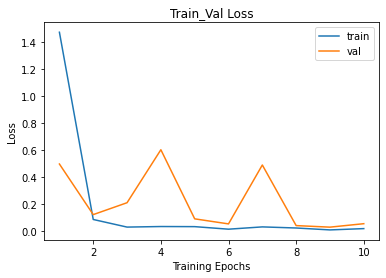

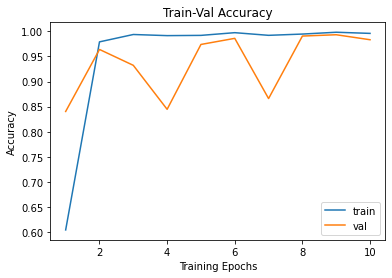

In [ ]:
  num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train_Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()